## Main objective of the analysis
The main objective of this analysis is to focus on time series forecasting. I used Bitcoin prices to test on different algorithms, including SARIMA, Facebook Prophet, SimpleRNN, LSTM and Exponential Smoothing techniques. Our goal is to find a best time series model to make Bitcoin price predictions as close as the actual prices on the test set.


In [1]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
# os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
# import fbprophet
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

In [3]:
# from dateutil.relativedelta import relativedelta
# def future_preds_df(model,series,num_months):
#     pred_first = series.index.max()+relativedelta(months=1)
#     pred_last = series.index.max()+relativedelta(months=num_months)
#     date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
#     vals = model.predict(n_periods = num_months)
#     return pd.DataFrame(vals,index = date_range_index)

In [4]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

### Load data and Preprocessing

In [5]:
df=pd.read_excel('Weekly BTC.xlsx',index_col = 'Date',parse_dates=['Date'])

In [6]:
df.tail()

,Price
Date,
2021-06-28,35287.78
2021-07-05,34240.19
2021-07-12,31796.81
2021-07-19,35350.19
2021-07-26,39406.94


In [7]:
df.head()

,Price
Date,
2014-09-15,398.82
2014-09-22,377.18
2014-09-29,320.51
2014-10-06,378.55
2014-10-13,389.55


In [107]:
df.describe()

,Price,log_ss,lag_8,seasonal_diff
count,359.000000,359.000000,351.000000,351.000000
mean,8290.593454,7.963781,7.906419,0.104492
std,12278.215494,1.637479,1.610730,0.329920
min,210.340000,5.353468,5.353468,-0.856194
25%,572.190000,6.351213,6.198942,-0.094660
50%,5167.720000,8.550380,8.385689,0.082766
75%,9402.935000,9.148882,9.128214,0.308557
max,60204.960000,11.005527,11.005527,1.158546


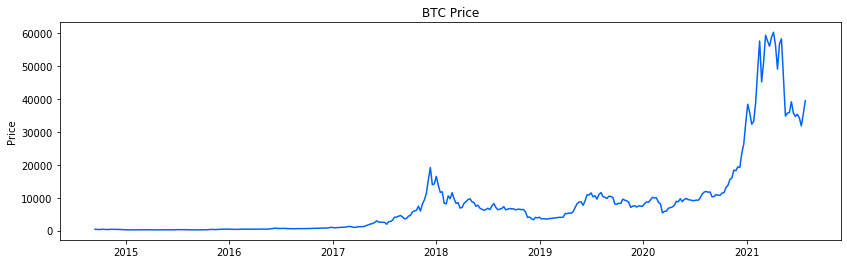

In [8]:
plt.figure(figsize=(14,4))
plt.plot(df.index,df['Price'])
plt.ylabel('Price')
plt.title('BTC Price');

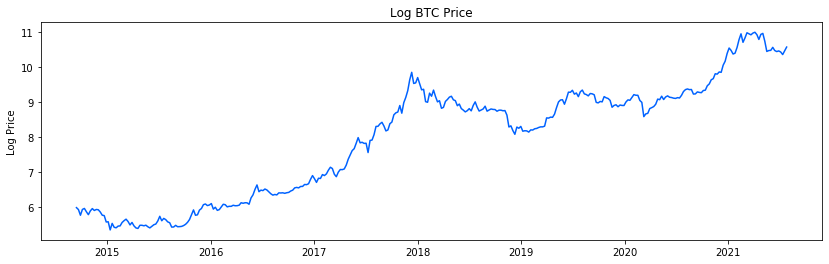

In [48]:
#given the difference in variance we should probably take log of data
df['log_ss'] = np.log1p(df['Price'])
# going to zoom in on last 60 values to get a better idea of frequency of seasonality
plt.figure(figsize=(14,4))
plt.plot(df['log_ss'])
plt.ylabel('Log Price')
plt.title('Log BTC Price');

In [10]:
plt.rcParams['figure.figsize'] = [14, 4]

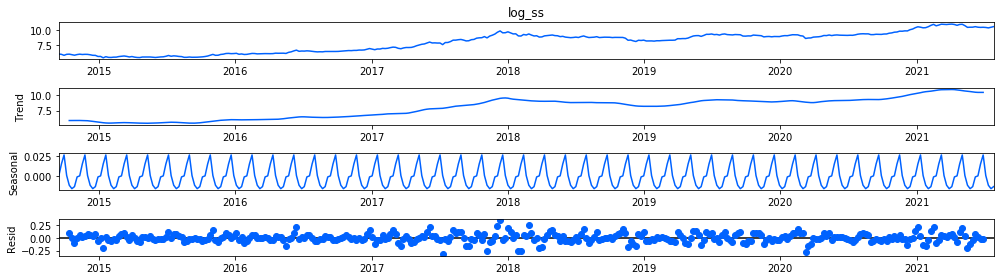

In [11]:
# plot decomposition with frequency 11
# Seems to do decent job of capturing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df.log_ss,model='additive',freq=8).plot();

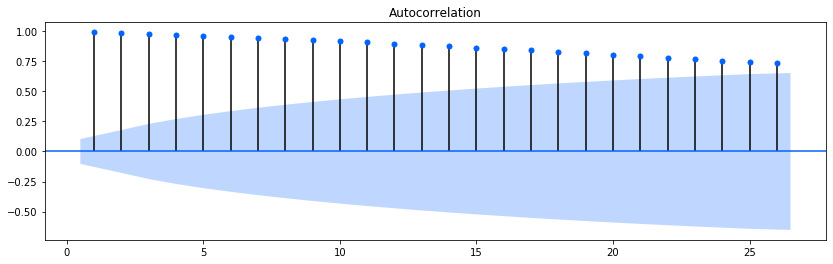

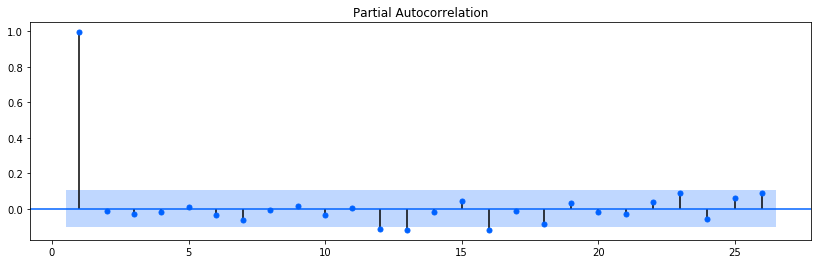

In [12]:
sm.tsa.graphics.plot_acf(df.log_ss,zero=False)
sm.tsa.graphics.plot_pacf(df.log_ss,zero = False);

In [13]:
df['lag_8'] = df.log_ss.shift(8)
df['seasonal_diff'] = df.log_ss - df['lag_8']

Test Statistic           -3.465232
p-value                   0.008926
Lags Used                17.000000
Observations Used       333.000000
Critical Value (1%)      -3.450141
Critical Value (5%)      -2.870259
Critical Value (10%)     -2.571415
dtype: float64


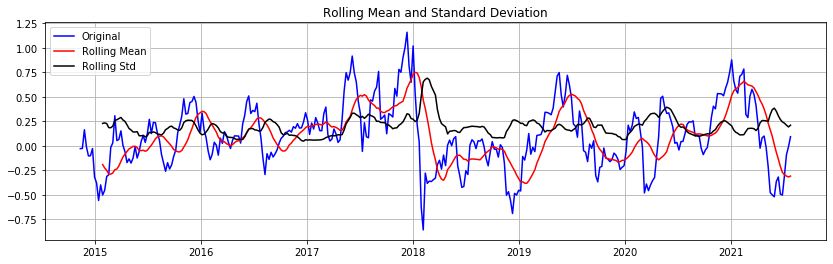

In [14]:
# mean moves, not perfect. p-value shows we can reject the null of non stationarity
dftest(df['seasonal_diff'].dropna())

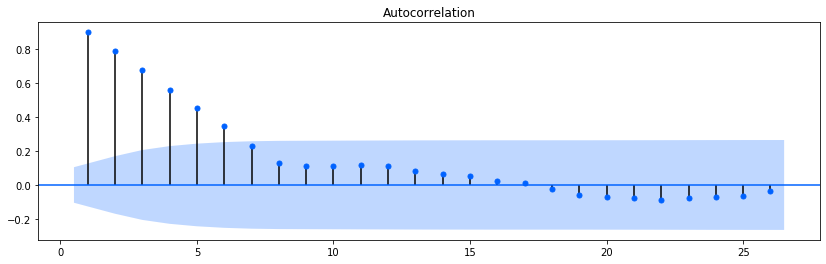

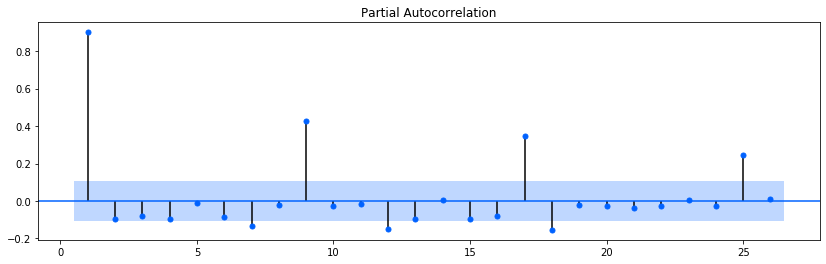

In [15]:
sm.tsa.graphics.plot_acf(df['seasonal_diff'].dropna(),zero=False)
sm.tsa.graphics.plot_pacf(df['seasonal_diff'].dropna(),zero=False);

### SARIMA Modeling - 1st attempt

In [16]:
sar3 = sm.tsa.statespace.SARIMAX(df.log_ss, 
                                order=(0,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

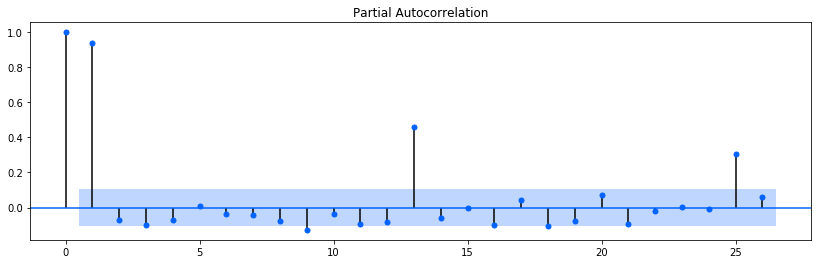

In [17]:
sm.tsa.graphics.plot_pacf(sar3.resid[sar3.loglikelihood_burn:]);

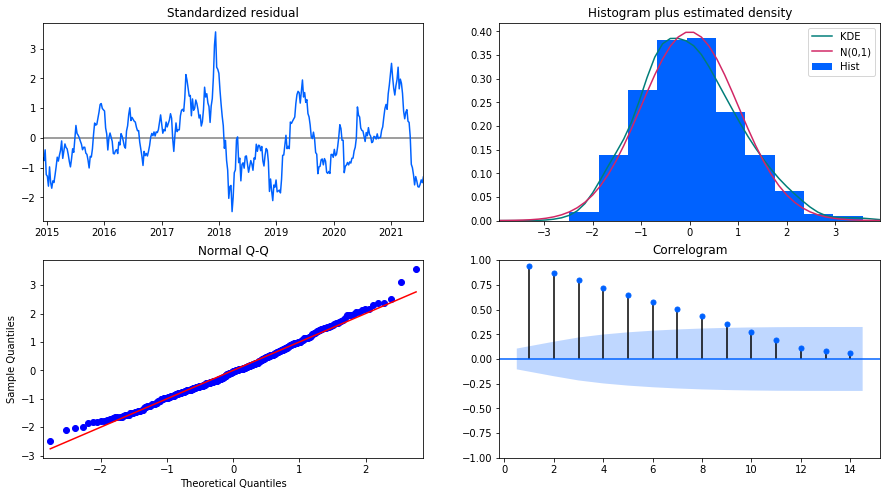

In [18]:
sar3.plot_diagnostics(figsize = (15,8),lags = range(1,15));

###### SARIMA Modeling - Auto_model

In [19]:
auto_model = pm.auto_arima(df.log_ss, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=8,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[8] intercept   : AIC=217.179, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[8] intercept   : AIC=220.641, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[8] intercept   : AIC=-425.829, Time=1.37 sec
 ARIMA(0,0,1)(0,1,1)[8] intercept   : AIC=-83.025, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[8]             : AIC=252.286, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[8] intercept   : AIC=-354.579, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[8] intercept   : AIC=-467.986, Time=1.98 sec
 ARIMA(1,0,0)(2,1,1)[8] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(1,0,0)(1,1,1)[8] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(2,1,0)[8] intercept   : AIC=218.815, Time=0.64 sec
 ARIMA(2,0,0)(2,1,0)[8] intercept   : AIC=-467.647, Time=3.02 sec
 ARIMA(1,0,1)(2,1,0)[8] intercept   : AIC=-467.450, Time=2.55 sec
 ARIMA(0,0,1)(2,1,0)[8] intercept   : AIC=-81.700, Time=1.47 sec
 ARIMA(2,0,1)(2,1,0)[8] intercept   : AIC=-468.211, Time=4.34 sec
 ARIMA(2,0,1)(1,1,0)[8] intercept   : AIC=-426.22

In [20]:
print('order: ',auto_model.order)
print('seasonal order: ',auto_model.seasonal_order)

order:  (1, 0, 0)
seasonal order:  (2, 1, 0, 8)


In [21]:
df.tail()

,Price,log_ss,lag_8,seasonal_diff
Date,,,,
2021-06-28,35287.78,10.471320,10.972213,-0.500893
2021-07-05,34240.19,10.441185,10.746284,-0.305099
2021-07-12,31796.81,10.367153,10.456556,-0.089403
2021-07-19,35350.19,10.473087,10.482321,-0.009234
2021-07-26,39406.94,10.581723,10.487472,0.094251


### Cross Validation

In [22]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [23]:
warnings.filterwarnings("ignore")
series = df['log_ss']
horizon = 3
start = int(len(df.Price)*.8)
step_size = 1
order = auto_model.order
seasonal_order = auto_model.seasonal_order

log_cv1 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [24]:
order

(1, 0, 0)

In [25]:
seasonal_order

(2, 1, 0, 8)

In [26]:
log_cv1 = np.expm1(log_cv1)

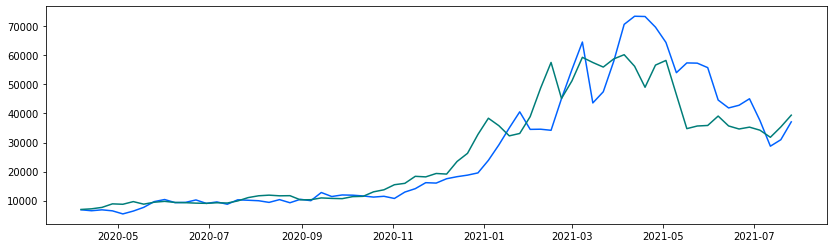

In [27]:
plt.plot(log_cv1)

In [28]:
mape(log_cv1)

0.2022518522361602

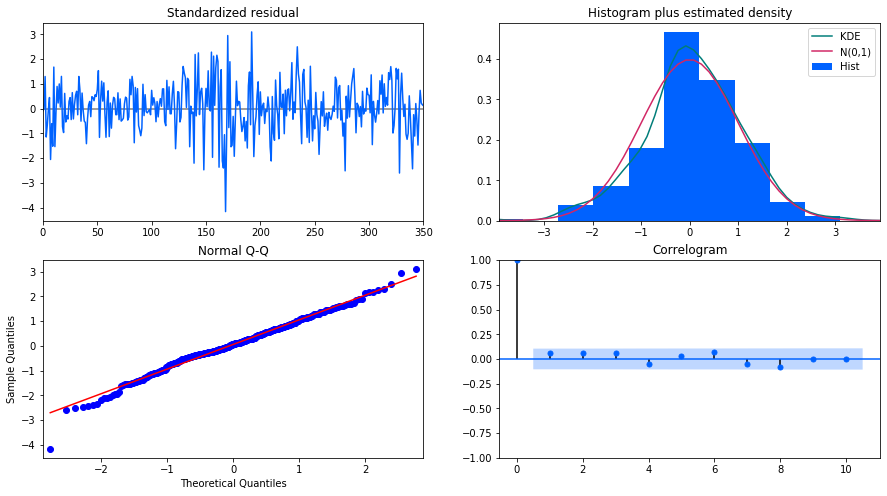

In [29]:
auto_model.plot_diagnostics(figsize = (15,8));

In [49]:
warnings.filterwarnings("ignore")
series = df['log_ss']
horizon = 3
start = int(len(df.Price)*.8)
step_size = 1
order = (2,0,0)
seasonal_order = (1,1,0,8)

log_cv2 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [50]:
log_cv2 = np.expm1(log_cv2)

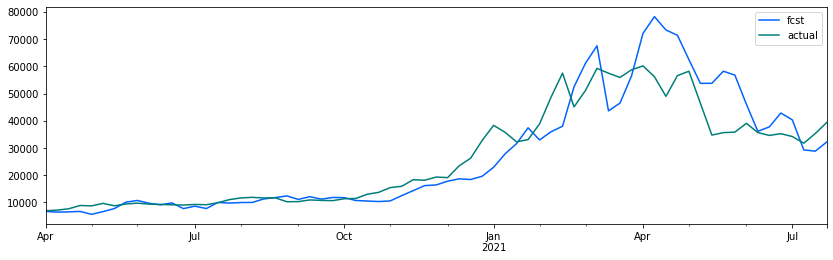

In [51]:
log_cv2.plot()

In [33]:
mape(log_cv2)

0.25556544091980243

In [37]:
sar_final = sm.tsa.statespace.SARIMAX(df.log_ss, 
                                order=(1, 0, 0), 
                                seasonal_order=(2, 1, 0, 8), 
                                trend='c').fit()

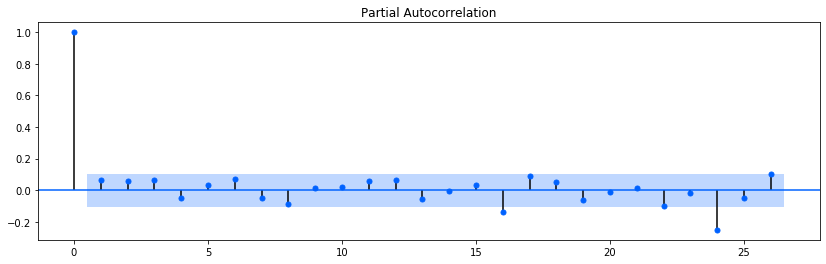

In [38]:
sm.tsa.graphics.plot_pacf(sar_final.resid[sar_final.loglikelihood_burn:]);

In [ ]:
sar_final.plot_diagnostics(figsize = (15,8),lags = range(1,15));

In [40]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_weeks):
    pred_first = series.index.max()+relativedelta(weeks=1)
    pred_last = series.index.max()+relativedelta(weeks=num_weeks)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'W')
    vals = model.predict(n_periods = num_weeks)
    return pd.DataFrame(vals,index = date_range_index)

In [41]:
vals = sar_final.predict(start= '2021-08-02', end= '2021-10-11')

In [42]:
pred_first = df['log_ss'].index.max()+relativedelta(weeks=1)
pred_last = df['log_ss'].index.max()+relativedelta(weeks=11)
date_range_index = pd.date_range(pred_first,pred_last,freq = '7D')

In [43]:
date_range_index

DatetimeIndex(['2021-08-02', '2021-08-09', '2021-08-16', '2021-08-23',
               '2021-08-30', '2021-09-06', '2021-09-13', '2021-09-20',
               '2021-09-27', '2021-10-04', '2021-10-11'],
              dtype='datetime64[ns]', freq='7D')

In [44]:
preds=pd.DataFrame(np.expm1(vals),index = date_range_index)

In [45]:
preds

,0
2021-08-02,43029.033889
2021-08-09,37241.049735
2021-08-16,40442.963741
2021-08-23,43718.749617
2021-08-30,40776.762206
2021-09-06,36802.741435
2021-09-13,39674.810642
2021-09-20,42200.176331
2021-09-27,43973.975893
2021-10-04,39031.869796


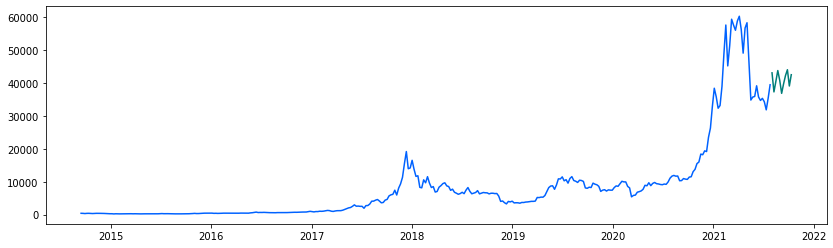

In [46]:
plt.plot(df.Price)
plt.plot(preds)

### FB Prophet

In [58]:
import fbprophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [59]:
from fbprophet import Prophet

In [60]:
df['ds'] = df.index

In [61]:
df_fb=df[['Price','ds']]

In [62]:
df_fb=df_fb.rename(columns={'Price':'y'})

In [63]:
model = Prophet()
model.fit(df_fb);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
# forecast 15 years into future
future = model.make_future_dataframe(periods=20, freq='7D', include_history=True)
future.tail()

#future = model.make_future_dataframe(periods=365*15)
#future.tail()

,ds
374,2021-11-15
375,2021-11-22
376,2021-11-29
377,2021-12-06
378,2021-12-13


In [65]:
# populate forecast
forecast = model.predict(future)

In [262]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
374,2021-11-15,51253.029728,43910.351188,57216.774388,50989.309145,51445.392769,-1124.083423,-1124.083423,-1124.083423,-1124.083423,-1124.083423,-1124.083423,0.0,0.0,0.0,50128.946305
375,2021-11-22,51725.992649,43875.396494,57704.498125,51428.207757,51936.177210,-824.630686,-824.630686,-824.630686,-824.630686,-824.630686,-824.630686,0.0,0.0,0.0,50901.361962
376,2021-11-29,52198.955570,44964.152976,58206.970341,51867.309261,52421.379662,-473.252499,-473.252499,-473.252499,-473.252499,-473.252499,-473.252499,0.0,0.0,0.0,51725.703071
377,2021-12-06,52671.918491,45578.178631,59048.172105,52317.077212,52936.731288,-218.582440,-218.582440,-218.582440,-218.582440,-218.582440,-218.582440,0.0,0.0,0.0,52453.336050
378,2021-12-13,53144.881412,46575.017281,59641.169897,52756.841672,53440.101893,82.649679,82.649679,82.649679,82.649679,82.649679,82.649679,0.0,0.0,0.0,53227.531091


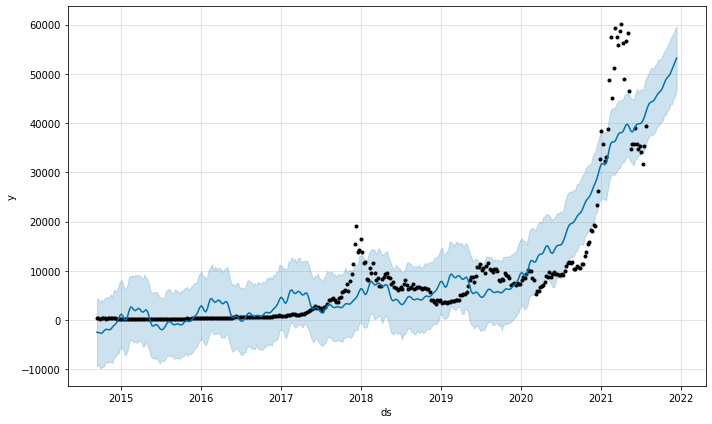

In [260]:
model.plot(forecast);

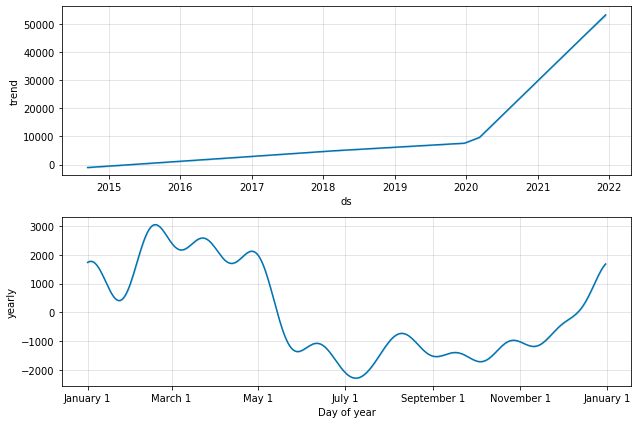

In [261]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
model.plot_components(forecast);

#### cross validation

In [267]:
df_train = df_fb['2014-09':'2021-05']
df_test = df_fb['2021-06':'2021-07-26']

In [268]:
# fit model
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [270]:
future = m.make_future_dataframe(periods = 50,freq = '7D') # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

          ds
0 2014-09-15
1 2014-09-22
2 2014-09-29
3 2014-10-06
4 2014-10-13


,ds
396,2022-04-18
397,2022-04-25
398,2022-05-02
399,2022-05-09
400,2022-05-16


In [271]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
396,2022-04-18,62909.241983,56040.399167,69605.732923
397,2022-04-25,63687.356207,56894.368500,71129.198539
398,2022-05-02,63991.631593,57245.042289,71088.062374
399,2022-05-09,63503.730143,55891.702784,70047.954640
400,2022-05-16,62651.245698,55553.554758,70301.646702


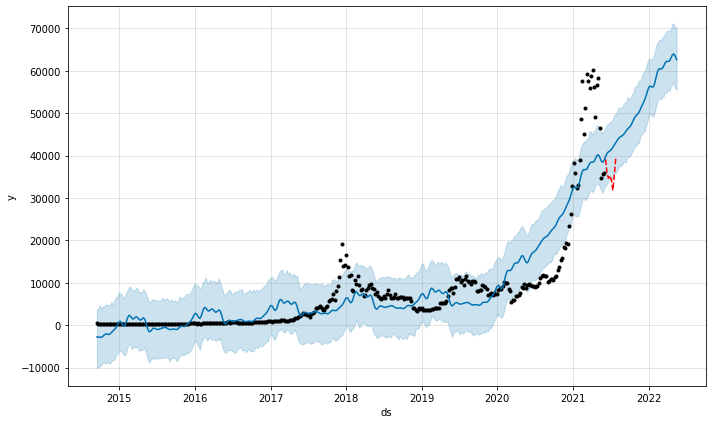

In [272]:
m.plot(forecast)
plt.plot(df_test.y,'r--')

#### adjustment

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


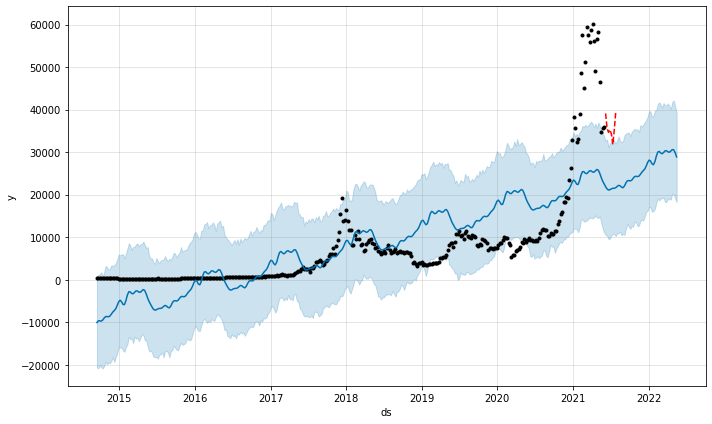

In [281]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.005
seasonality_prior_scale = 1


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

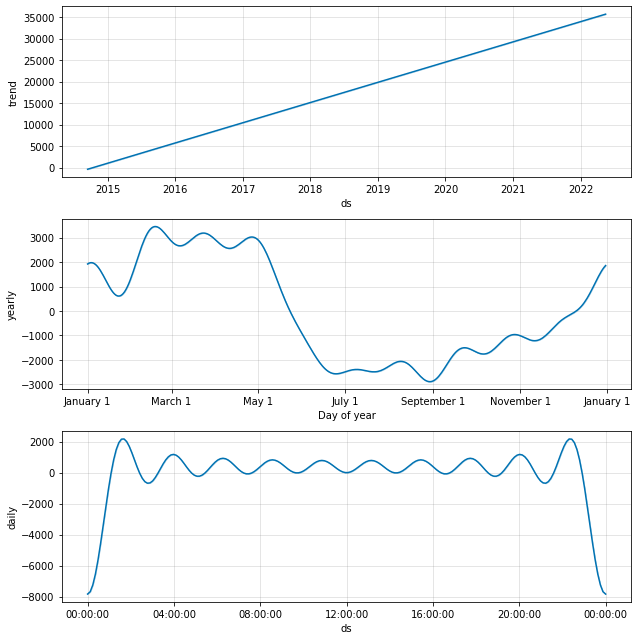

In [282]:
m.plot_components(forecast);

### Deep Learning

#### RNN

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
# os.chdir('data')
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [18]:
df.head()

,Price,log_ss,lag_8,seasonal_diff
Date,,,,
2014-09-15,398.82,5.991014,NaN,NaN
2014-09-22,377.18,5.935370,NaN,NaN
2014-09-29,320.51,5.773029,NaN,NaN
2014-10-06,378.55,5.938986,NaN,NaN
2014-10-13,389.55,5.967556,NaN,NaN


In [19]:
scaler=MinMaxScaler()
df['Price_norm']=scaler.fit_transform(df[['Price']])

In [20]:
df['scaler_back']=scaler.inverse_transform(df[['Price_norm']])

In [41]:
df.head()

,Price,log_ss,lag_8,seasonal_diff,Price_norm,scaler_back
Date,,,,,,
2014-09-15,398.82,5.991014,NaN,NaN,0.003142,398.82
2014-09-22,377.18,5.935370,NaN,NaN,0.002781,377.18
2014-09-29,320.51,5.773029,NaN,NaN,0.001836,320.51
2014-10-06,378.55,5.938986,NaN,NaN,0.002804,378.55
2014-10-13,389.55,5.967556,NaN,NaN,0.002987,389.55


In [22]:
def get_n_last_weeks(df, series_name, n_weeks):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(n_weeks):] 

In [23]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_weeks, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_weeks(df, series_name, series_weeks).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [24]:
series_weeks = 500
input_hours = 20
test_hours = 40

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'Price_norm', series_weeks, 
                         input_hours, test_hours))

In [25]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (100, 20, 1)
Training output shape: (100,)
Test input shape: (20,)
Test output shape: (20,)


In [42]:
test_X_init

array([0.22546638, 0.25450999, 0.26244437, 0.30268814, 0.29947919,
       0.3189416 , 0.3155623 , 0.38781727, 0.43440478, 0.54291001,
       0.63582535, 0.59306885, 0.53469861, 0.54844951, 0.64494283,
       0.80852166, 0.95557918, 0.74885765, 0.85001538, 0.98495465])

In [43]:
pd.DataFrame(test_X_init)

,0
0,0.225466
1,0.254510
2,0.262444
3,0.302688
4,0.299479
5,0.318942
6,0.315562
7,0.387817
8,0.434405
9,0.542910


In [44]:
scaler.inverse_transform(pd.DataFrame(test_X_init))

array([[13737.11],
       [15479.57],
       [15955.59],
       [18370.  ],
       [18177.48],
       [19345.12],
       [19142.38],
       [23477.29],
       [26272.29],
       [32782.02],
       [38356.44],
       [35791.28],
       [32289.38],
       [33114.36],
       [38903.44],
       [48717.29],
       [57539.95],
       [45137.77],
       [51206.69],
       [59302.32]])

In [48]:
test_X_init

array([0.22546638, 0.25450999, 0.26244437, 0.30268814, 0.29947919,
       0.3189416 , 0.3155623 , 0.38781727, 0.43440478, 0.54291001,
       0.63582535, 0.59306885, 0.53469861, 0.54844951, 0.64494283,
       0.80852166, 0.95557918, 0.74885765, 0.85001538, 0.98495465])

In [29]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [30]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [50]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

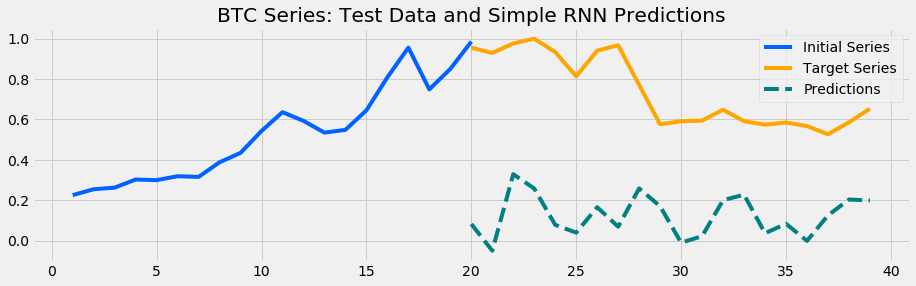

In [51]:
predict_and_plot(test_X_init, test_y, model,
                 'BTC Series: Test Data and Simple RNN Predictions')

In [423]:
data_1=pd.DataFrame()
data_1['scaler']=[1,2,3,4,5,6,7,8]

In [432]:
a1=scaler.fit_transform(data_1)

In [433]:
scaler.inverse_transform(a1)

array([[1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.]])

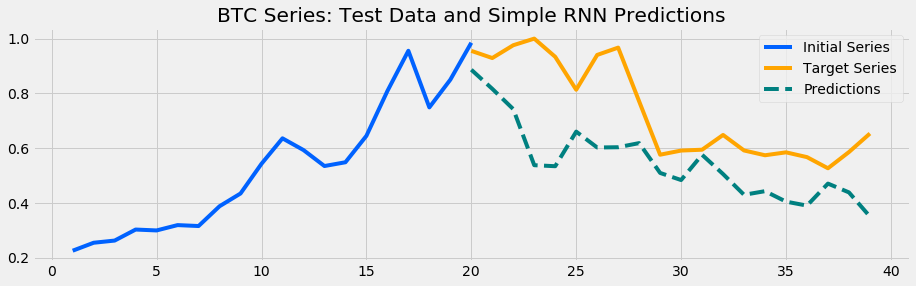

In [52]:
model = fit_SimpleRNN(train_X, train_y, cell_units=80, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'BTC Series: Test Data and Simple RNN Predictions')

In [393]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 80)                6560      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 81        
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________


#### LSTM

In [53]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
#     model.add(Dense(cell_units/2)) #,return_sequences= True))
    
#     model.add(Dense(cell_units/2)) #,return_sequences= True))

    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

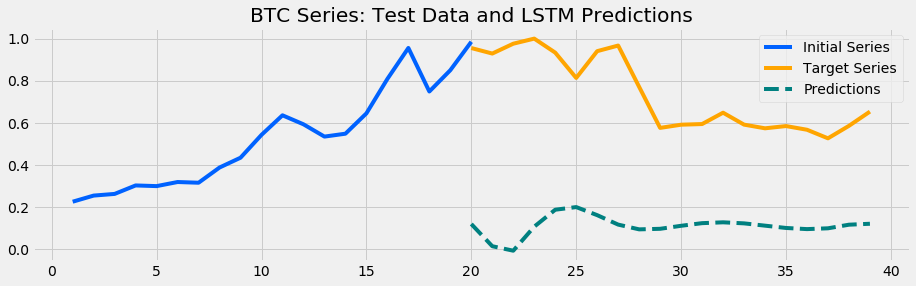

In [54]:
series_weeks = 500
input_hours = 20
test_hours = 40

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'Price_norm', series_weeks, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=150, epochs=2000) 

predict_and_plot(test_X_init, test_y, model, 
                 'BTC Series: Test Data and LSTM Predictions')

In [315]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


### Exponential Smoothing

In [66]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [124]:
nn=8

In [125]:
train = np.array(df.Price[:-nn])
test = np.array(df.Price[-nn:])

In [126]:
time=np.array(df.ds)

In [127]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=8).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [35112.9241742  33057.51637181 36065.45159258 35421.78505008
 32352.89779405 32163.89056938 34159.32173442 34707.27337919]
MSE:  52077585.11353918


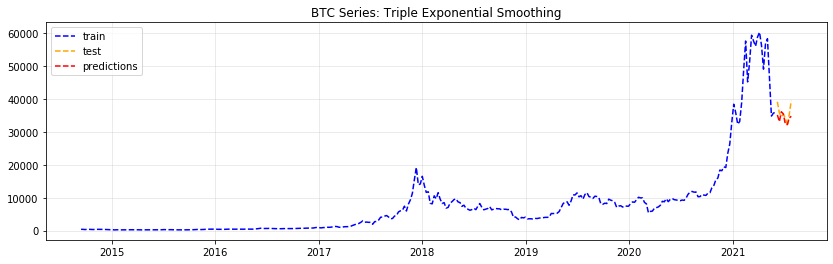

In [128]:
plt.plot(time[:-nn], train, 'b--', label="train")
plt.plot(time[-nn:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-nn:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("BTC Series: Triple Exponential Smoothing")
plt.grid(alpha=0.3);

In [129]:
test

array([39097.86, 35698.3 , 34649.64, 35287.78, 34240.19, 31796.81,
       35350.19, 39406.94])

In [130]:
triple_preds

array([35112.9241742 , 33057.51637181, 36065.45159258, 35421.78505008,
       32352.89779405, 32163.89056938, 34159.32173442, 34707.27337919])

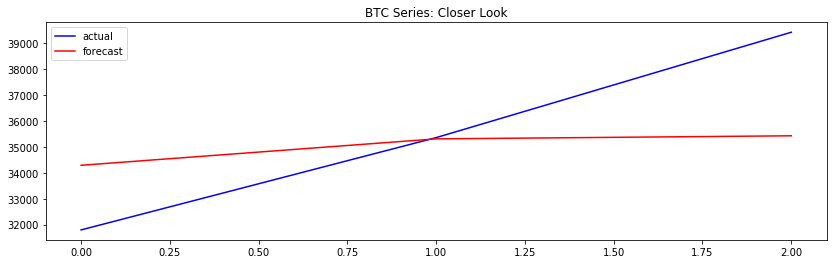

In [123]:
plt.plot(test,'b-',label='actual')
plt.plot(triple_preds,'r-',label='forecast')
plt.title('BTC Series: Closer Look')
plt.legend()
plt.show()